## **Noise Filtering**

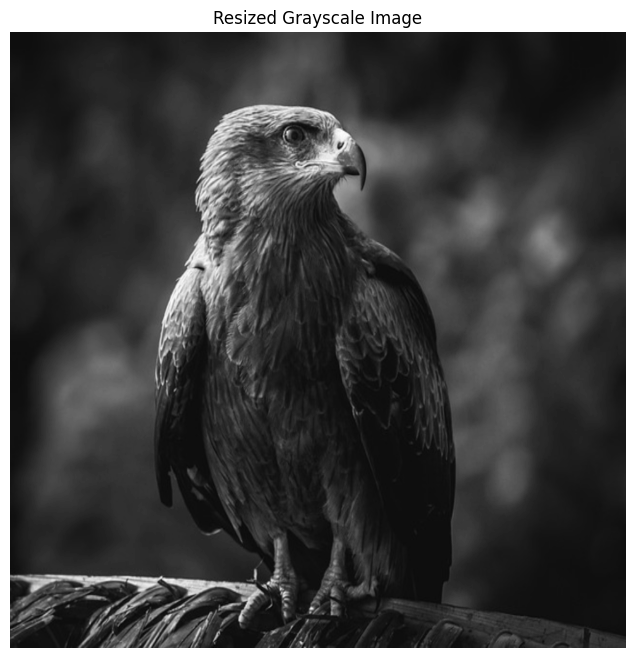

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image in grayscale and resize
img = cv2.imread('image-2.jpg', cv2.IMREAD_GRAYSCALE)
img_resized = cv2.resize(img, (1000, 1000))
plt.figure(figsize=(8, 8))
plt.imshow(img_resized, cmap='gray')
plt.title("Resized Grayscale Image")
plt.axis('off')  
plt.show()


# Function to display images
def display_images(original, noisy, filter_name):
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.title('Original Image')
    plt.imshow(original, cmap='gray')
    plt.subplot(122)
    plt.title(filter_name)
    plt.imshow(noisy, cmap='gray')
    plt.tight_layout()
    plt.show()

## **Salt and Pepper Noise**

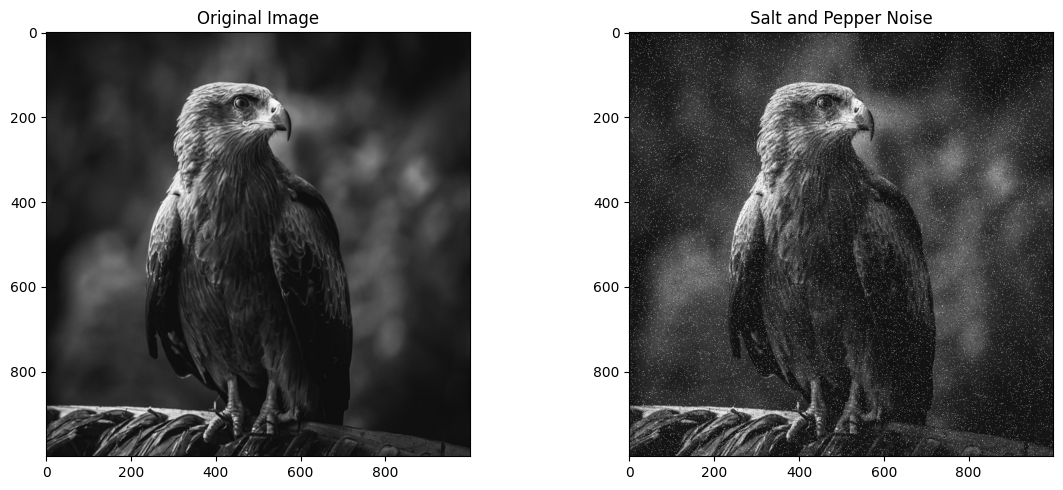

In [5]:
# a) Salt and Pepper Noise
def add_salt_pepper_noise(image, prob=0.05):
    noisy = np.copy(image)
    num_salt = np.ceil(prob * image.size * 0.5)
    num_pepper = np.ceil(prob * image.size * 0.5)
    
    # Salt
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    noisy[coords[0], coords[1]] = 255
    
    # Pepper
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    noisy[coords[0], coords[1]] = 0
    
    return noisy

salt_pepper_noisy = add_salt_pepper_noise(img_resized)
display_images(img_resized, salt_pepper_noisy, 'Salt and Pepper Noise')



## **Uniform Noise**

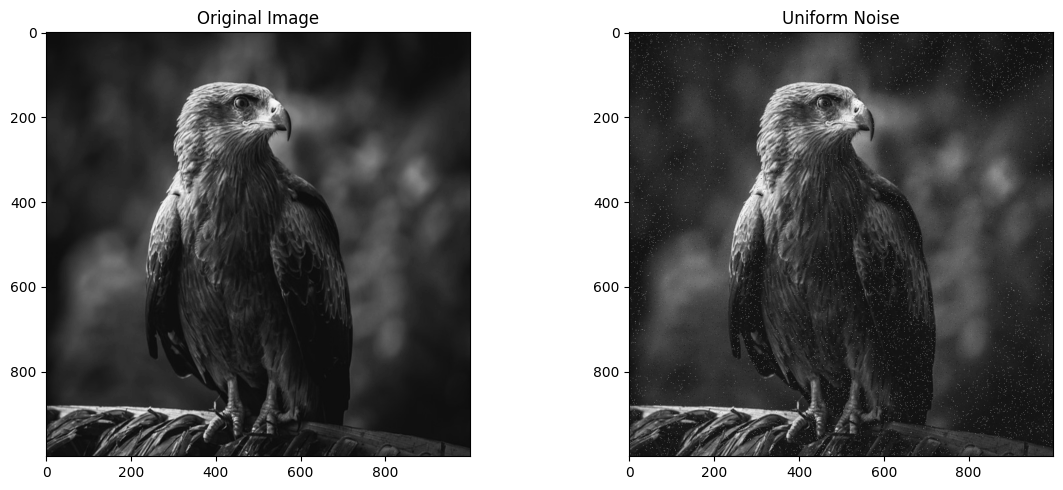

In [6]:
# b) Uniform Noise
def add_uniform_noise(image, prob=0.05):
    noisy = np.copy(image)
    num_noise = np.ceil(prob * image.size)
    coords = [np.random.randint(0, i - 1, int(num_noise)) for i in image.shape]
    noise_vals = np.random.uniform(-50, 50, int(num_noise))
    noisy[coords[0], coords[1]] += noise_vals.astype(np.uint8)
    return np.clip(noisy, 0, 255)

uniform_noisy = add_uniform_noise(img_resized)
display_images(img_resized, uniform_noisy, 'Uniform Noise')



## **Gaussian Noise**

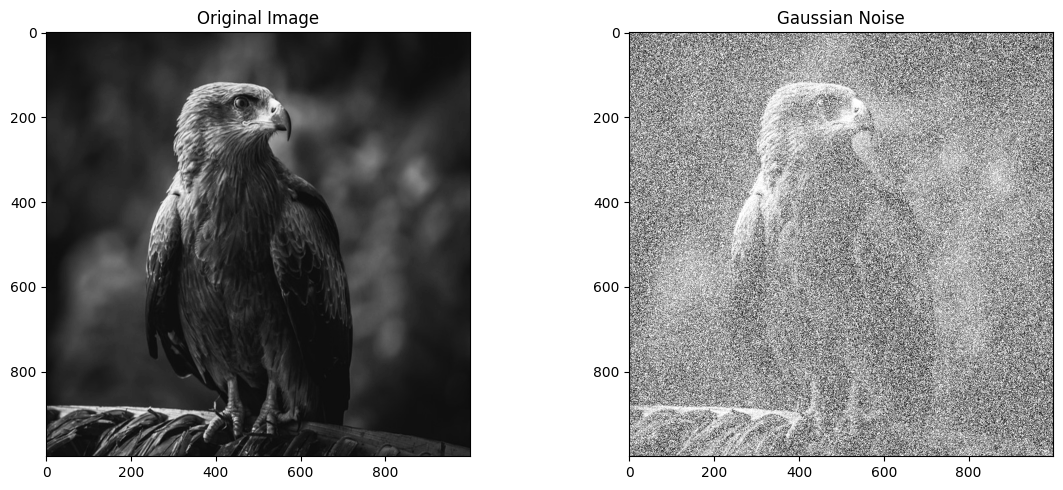

In [7]:
# c) Gaussian Noise
def add_gaussian_noise(image, mean=0, sigma=25):
    noisy = np.copy(image)
    gauss = np.random.normal(mean, sigma, image.shape).astype(np.uint8)
    noisy = cv2.add(noisy, gauss)
    return np.clip(noisy, 0, 255)

gaussian_noisy = add_gaussian_noise(img_resized)
display_images(img_resized, gaussian_noisy, 'Gaussian Noise')



## **Filtering with different kernel sizes**

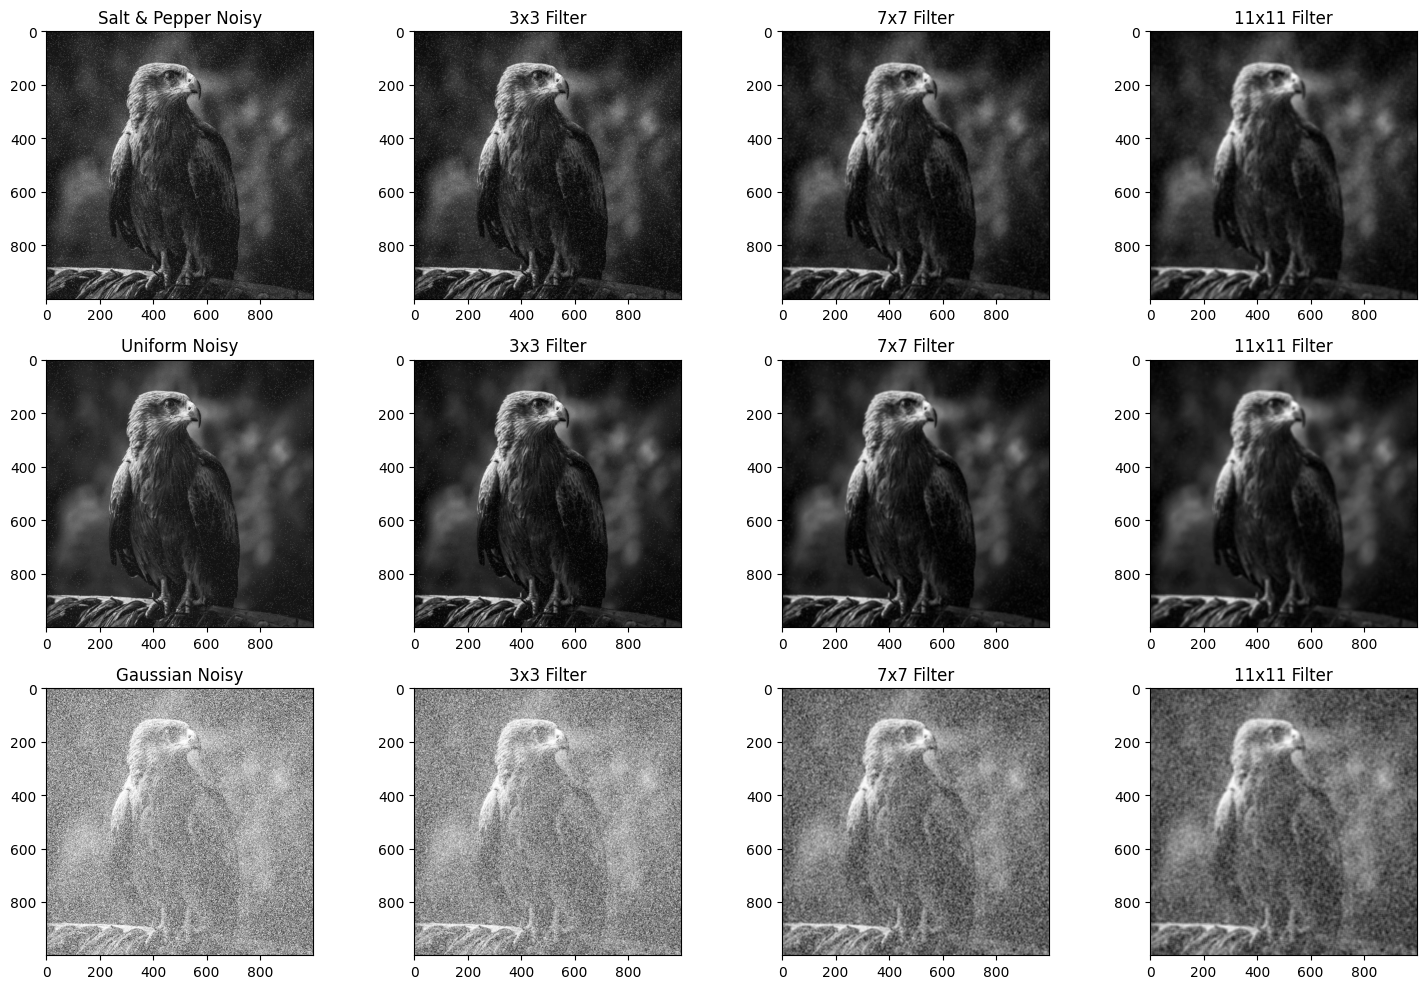

In [8]:
# d) Filtering with different kernel sizes
def uniform_filter(image, kernel_size):
    kernel = np.ones((kernel_size, kernel_size)) / (kernel_size * kernel_size)
    return cv2.filter2D(image, -1, kernel)

# Filtering noisy images
kernel_sizes = [3, 7, 11]
noisy_images = [salt_pepper_noisy, uniform_noisy, gaussian_noisy]
noise_names = ['Salt & Pepper', 'Uniform', 'Gaussian']

plt.figure(figsize=(15, 10))
for i, (noisy_img, noise_name) in enumerate(zip(noisy_images, noise_names)):
    plt.subplot(3, 4, i*4 + 1)
    plt.title(f'{noise_name} Noisy')
    plt.imshow(noisy_img, cmap='gray')
    
    for j, kernel_size in enumerate(kernel_sizes):
        filtered = uniform_filter(noisy_img, kernel_size)
        plt.subplot(3, 4, i*4 + j + 2)
        plt.title(f'{kernel_size}x{kernel_size} Filter')
        plt.imshow(filtered, cmap='gray')

plt.tight_layout()
plt.show()



## **Order Statistic Filters for Salt and Pepper Noise**

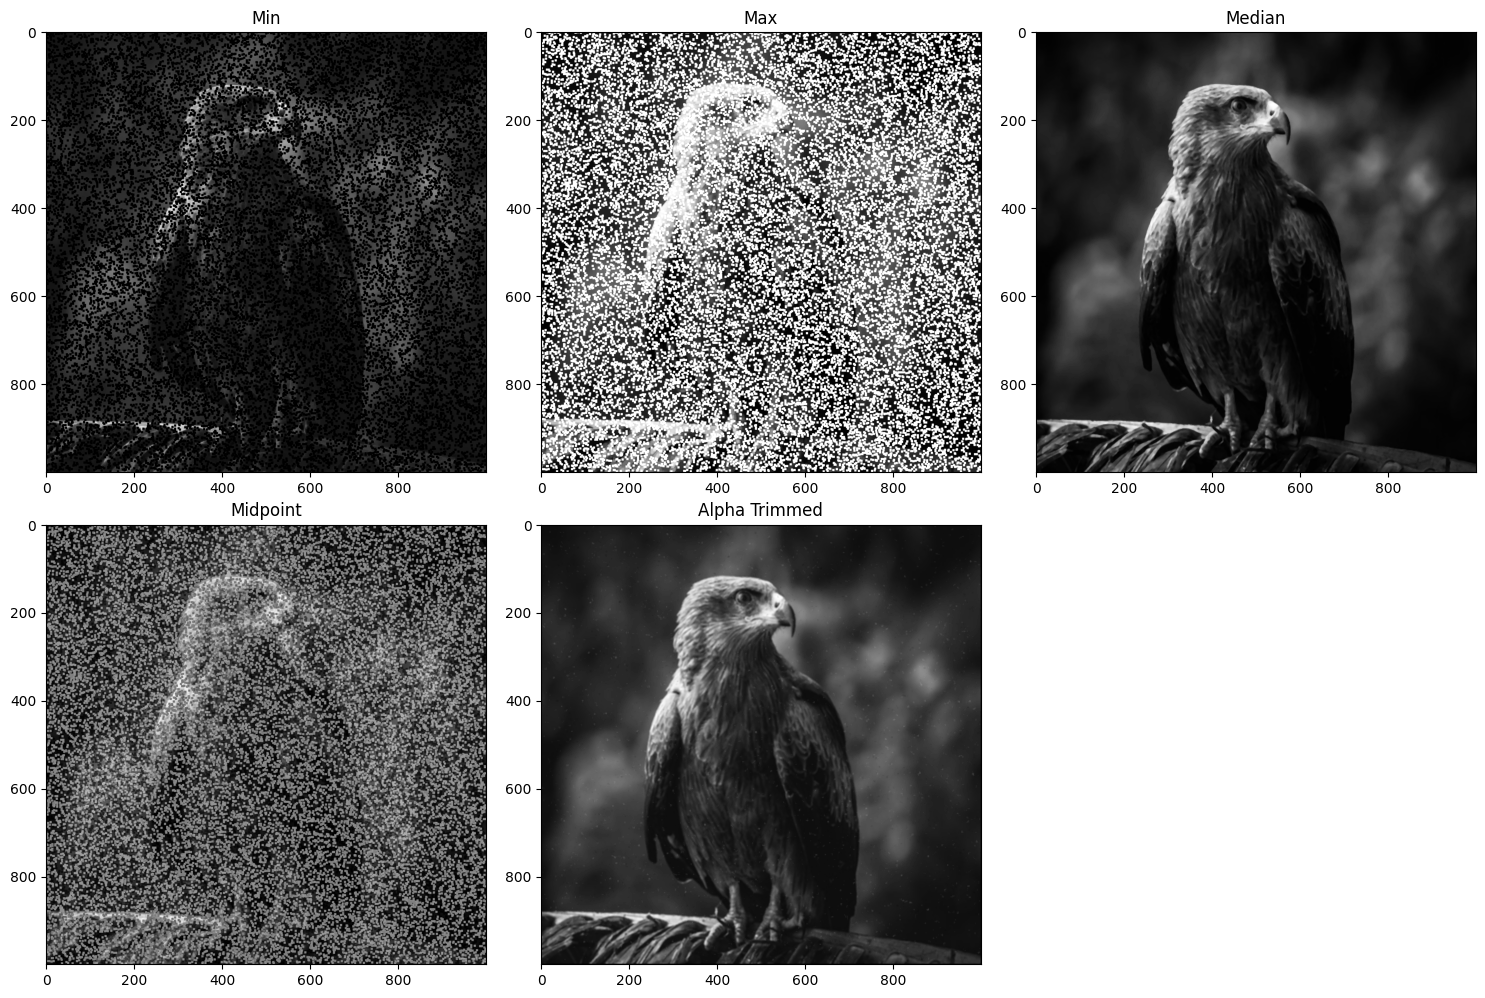

In [9]:
# e) Order Statistic Filters for Salt and Pepper Noise
def min_filter(image, window_size=5):
    return cv2.erode(image, np.ones((window_size, window_size), np.uint8))

def max_filter(image, window_size=5):
    return cv2.dilate(image, np.ones((window_size, window_size), np.uint8))

def median_filter(image, window_size=5):
    return cv2.medianBlur(image, window_size)

def midpoint_filter(image, window_size=5):
    min_img = min_filter(image, window_size)
    max_img = max_filter(image, window_size)
    return ((min_img.astype(float) + max_img.astype(float)) / 2).astype(np.uint8)

def alpha_trimmed_filter(image, window_size=5, k=2):
    def alpha_trimmed_mean(window):
        sorted_window = np.sort(window.flatten())
        return np.mean(sorted_window[k:-k])
    
    # Create a padded image
    pad = window_size // 2
    padded = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=0)
    
    # Create output image
    output = np.zeros_like(image)
    
    # Apply alpha-trimmed mean filter
    for i in range(pad, padded.shape[0] - pad):
        for j in range(pad, padded.shape[1] - pad):
            window = padded[i-pad:i+pad+1, j-pad:j+pad+1]
            output[i-pad, j-pad] = alpha_trimmed_mean(window)
    
    return output.astype(np.uint8)

# Display order statistic filters
plt.figure(figsize=(15, 10))
filter_funcs = [min_filter, max_filter, median_filter, midpoint_filter, alpha_trimmed_filter]
filter_names = ['Min', 'Max', 'Median', 'Midpoint', 'Alpha Trimmed']

for i, (filter_func, filter_name) in enumerate(zip(filter_funcs, filter_names)):
    filtered = filter_func(salt_pepper_noisy)
    plt.subplot(2, 3, i + 1)
    plt.title(filter_name)
    plt.imshow(filtered, cmap='gray')

plt.tight_layout()
plt.show()



## **Geometric Mean Filter for Salt and Pepper Noise**

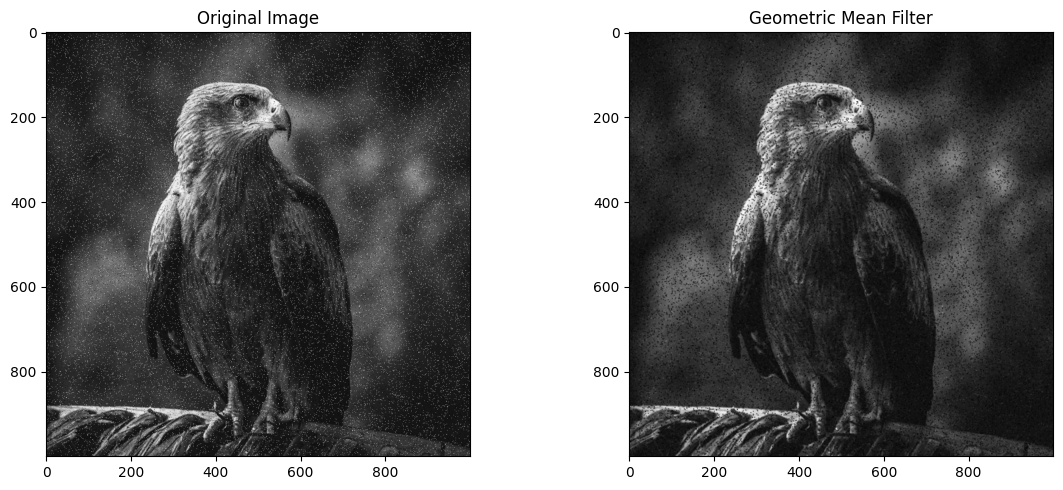

In [10]:
# f) Geometric Mean Filter for Salt and Pepper Noise
def geometric_mean_filter(image, kernel_size):
    half_k = kernel_size // 2
    padded = cv2.copyMakeBorder(image, half_k, half_k, half_k, half_k, cv2.BORDER_REFLECT)
    filtered = np.zeros_like(image, dtype=np.float64)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            window = padded[i:i+kernel_size, j:j+kernel_size]
            filtered[i, j] = np.exp(np.mean(np.log1p(window))) - 1
    return np.clip(filtered, 0, 255).astype(np.uint8)

geometric_filtered = geometric_mean_filter(salt_pepper_noisy, 3)
display_images(salt_pepper_noisy, geometric_filtered, 'Geometric Mean Filter')

plt.show()